<a href="https://colab.research.google.com/github/Param-Bhatt/Ray-Tracer/blob/master/RayTracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

Here we have defined the variables for the width and height of our viewing window , can change it accordingly

In [0]:
w = 400
h = 300

The normalize function of numpy is used to get the unit vector of the vector that we supply to it as an argument , here x.

In [0]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x

<li> O is our camera</li>
<li> Q is the pixel at which our camera is pointing </li>
<li> N is our normal vector of the plane</li>
<li> D is our point of intersection with the plane. Hence OD will be ray directon here. </li>
<li> P is our random point on the plane. The plane will be represented as P,N </li>

In [0]:
def intersect_plane(O, D, P, N):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # plane (P, N), or +inf if there is no intersection.
    # O and P are 3D points, D and N (normal) are normalized vectors.
    denom = np.dot(D, N)
    if np.abs(denom) < 1e-6:
        return np.inf
    d = np.dot(P - O, N) / denom
    if d < 0:
        return np.inf
    return d

<li>O is our camera (<i>Its a point</i>)</li>
<li>D is the intersection point of the ray and sphere</li>
<li>S is center of sphere</li>
<li>R is is the radius of the sphere</li>

This function gives us 2 points of intersection of the ray with our sphere

In [0]:
def intersect_sphere(O, D, S, R):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    a = np.dot(D, D) #dot product of D with itself, basically we get its magnitude
    OS = O - S 
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf #returning infinity incase there is no point of intersection

A function to segregate between intersection of the ray with our plane or with our image

In [0]:
def intersect(O, D, obj):
    if obj['type'] == 'plane':
        return intersect_plane(O, D, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return intersect_sphere(O, D, obj['position'], obj['radius'])

We love playing with normals here, hence this function is just for finding the unit normal of any given object.<br> We first check for the type of object from the object dictionary. 
<li>Since we stored the normal of the plane with the object itself, we can straight away give the normal to the plane.</li>
<li>For sphere we normalise the ray from M to the center of our sphere , which then becomes our normal.
</li>
<li>M here is M = rayO + rayD * t , the equation we use to traverse across the intersection points of our objects with the rays
</li>
<li>N returned here is the unit normal of that respective object</li>

In [0]:
def get_normal(obj, M):
    # Find normal.
    if obj['type'] == 'sphere':
        N = normalize(M - obj['position'])
    elif obj['type'] == 'plane':
        N = obj['normal']
    return N

This function is used for choosing the color and making any changes to it whatsoever required. Based on the object , we assign it the colour.
<li>M here is M = rayO + rayD * t , the equation we use to traverse across the intersection points of our objects with the rays.
</li>
<li> Color returned is the color of the object in question , and this is what we will paint it with . </li>

In [0]:
def get_color(obj, M):
    color = obj['color']
    if not hasattr(color, '__len__'):
        color = color(M)
    return color

<h3>The function arguments</h3>
<li>rayO is the ray origin . This will be the starting point of our ray from which we will make the ray</li>
<li>rayD is the ray direction. From the ray origin, the ray will pass through the center of the pixel that we will be looking at. The ray in this direction will be labelled as rayD</li>
<h3>Find the point of intersection with the scene</h3>
<li>The enumerate function is used to go through the entire scene, it adds a counter to it's function arguments and hence ,we can iterate through the entire scene in one loop. </li>
<li>We supply ray origin and raydir and find out the intersection point , and then store them in t_obj. Since we intialised t to infinity, if we get any intersection point , we will store it along with the index to remember it in the future.</li>
<li>Once we exit the loop , we check if t is still infinity. If it is , that means there are no intersection points and hence we return null value , or the background color.</li>
<li>The line "obj = scene[obj_idx]" means that we take the object. the object index will tell us which one it is , in this case , whether its sphere#1,#2,#3 or the plane. We store this value in obj.
<li>To traverse through the intersection point, we start at ray origin, and then traverse t distance ( t is the intersection point ) in ray dir. Its a scalar*vector multiplication .
<li>Then we get the properties of object , namely , it's normal to the intersection point and it's color.
<li>toL and toO are our normalised vectors. toL is the vector from M to L (<i>L is our light source ki position)</i>. toO is the vector from M to O <i>(O is the position of our camera)</i>
<h3>Game of Shadows</h3>
<li>This time , we start moving from M. This will be our reflected ray , so this time our ray origin becomes M. However , to avoid code being messy and all , we carry on with M as our new ray origin.
<li> Since N is the normal , this is our new ray dir. Why is it so? Coz after light hits a point , it is always going to be reflected in the direction of the normal from the center to the point of intersection, the 90degree angle change will happen. We are ignoring diffused reflection here , only normal reflection is being considered.
<li>Again we iterate through all the elements of the scene and check for their intersection. If there <i>are no intersections</i> , then we can <i>light</i> the pixel with suitable color. However, if there <i>are one or more intersections </i> , then <i>we cast a shadow on it </i>.
<li>Coloring time....yaay 
<br>Default light and material parameters.<br>
&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp ambient = .05<br>
&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp diffuse_c = 1.<br>
&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp specular_c = 1.<br>
&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp specular_k = 50<br>


In [0]:
def trace_ray(rayO, rayD):
    # Find first point of intersection with the scene.
    t = np.inf
    for i, obj in enumerate(scene):
        t_obj = intersect(rayO, rayD, obj)
        if t_obj < t:
            t, obj_idx = t_obj, i
    # Return None if the ray does not intersect any object.
    if t == np.inf:
        return
    # Find the object.
    obj = scene[obj_idx]
    # Find the point of intersection on the object.
    M = rayO + rayD * t #traverse to the intersection points
    # Find properties of the object.
    N = get_normal(obj, M)
    color = get_color(obj, M)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Shadow: find if the point is shadowed or not.
    l = [intersect(M + N * .0001, toL, obj_sh) 
            for k, obj_sh in enumerate(scene) if k != obj_idx]
    if l and min(l) < np.inf:
        return
    # Start computing the color.
    col_ray = ambient
    # Lambert shading (diffuse).
    col_ray += obj.get('diffuse_c', diffuse_c) * max(np.dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col_ray += obj.get('specular_c', specular_c) * max(np.dot(N, normalize(toL + toO)), 0) ** specular_k * color_light
    return obj, M, N, col_ray

The add_sphere function adds a sphere as a dictionary along with its position , radius , color and reflectivity<br>
The parameters of each sphere are : 
<li>Type is sphere</li>
<li>Position <i>(maybe the centre, an assumption of Param)</i></li>
<li>Radius of the sphere</li>
<li>Color of the sphere</li>
<li>Reflection by the sphere </li>


In [0]:
def add_sphere(position, radius, color):
    return dict(type='sphere', position=np.array(position), 
        radius=np.array(radius), color=np.array(color), reflection=.5)

add_plane function will add our chess type plane here. the color is chosen on the basis of even odd from the starting , rest all values are set at a default
<br>The parameters of the plane are : 
<li> A type plane </li>
<li> A position </li>
<li> A normal </li>
<li> The colour , as intermitting black and white squares </li>
<li> Diffuse_color </li>
<li> Specular_color</li>
<li> Reflection</li>

In [0]:
def add_plane(position, normal):
    return dict(type='plane', position=np.array(position), 
        normal=np.array(normal),
        color=lambda M: (color_plane0 
            if (int(M[0] * 2) % 2) == (int(M[2] * 2) % 2) else color_plane1),
        diffuse_c=.75, specular_c=.5, reflection=.25)    

We start out by defining our objects. color_plane0 and color_plane1 are 3x1 matrices consisting of 1 and 0 respectively. We then add 3 spheres and a ground to our scene.

In [0]:
# List of objects.
color_plane0 = 1. * np.ones(3)
color_plane1 = 0. * np.ones(3)
scene = [add_sphere([.75, .1, 1.], .6, [0., 0., 1.]),
         add_sphere([-.75, .1, 2.25], .6, [.5, .223, .5]),
         add_sphere([-2.75, .1, 3.5], .6, [1., .572, .184]),
         add_plane([0., -.5, 0.], [0., 1., 0.]),
    ]


We start of with light positioned at (5,5,-10). Z-coordinate is negative , hence the light point is <u>behind us into the screen</u>. The color is initalised to (1,1,1) which is white. <br>
The default parameters are intialised accordingly.
<ol>All are initialised to x,y,z coordinates here:
<li> O is our camera . </li>
    <li> Q is the pixel where our camera is pointing at.</li>
    <li>We initialise imgage of shape 300*400 here , and each pixel will be a 3d array consisting of all 3 coordiantes.</li>

In [0]:
# Light position and color.
L = np.array([5., 5., -10.])
color_light = np.ones(3)

# Default light and material parameters.
ambient = .05
diffuse_c = 1.
specular_c = 1.
specular_k = 50

depth_max = 5  # Maximum number of light reflections.
col = np.zeros(3)  # Current color.
O = np.array([0., 0.35, -1.])  # Camera.
Q = np.array([0., 0., 0.])  # Camera pointing to.
img = np.zeros((h, w, 3)) # Image window

<li>Aspect ratio : 'r' is our aspect ratio .
<li> We start off from screen coordinates x0,y0,x1,y1 and traverse through the entire screen.
<li>np.linspace is used for iterating through a lot of values.<i>(For more information , go : <a href="https://www.geeksforgeeks.org/numpy-linspace-python/"> here</a>)</i>. Speaking in layman terms, we iterate through the entire scene, the first loop is for going along width and the nested loop is for going along the height.
<li>we initialise the entire column arrays to 0 and the first 2 elements of the Q array to x and y co-ordinates.
<li>D is the unit vector from Q to 0. 
<li> We are starting with depth 0. The more depth we can keep , the better our resulting image will be. However , it is computationally heavy , so we have kept it at depth 5.
<li> We set the ray origin to be the graphical origin (0,0,0) and ray direction to be the respective x and y of the particular pixel we are investigating. 
<li> We have kept reflection to 1 , which means that reflection is there.
<li> Our function trace_ray returns the object, its intersection point with the current ray , the normal from the center (<i>position</i>) of our object to the point and the color of the particular pixel.<b><br>If it does not return anything, it means there is no pixel to be coloured , and hence should be same as the background scene </b>
<li>Once traced the ray , we assign those values from the traced data type into our variables here. 
<li> Now we go towards reflection. Just like in the reflection , we take ray origin and ray direction as M+N*xxx and unit vector in the normal directio respectively.
<li> We multiply and add the color multiplied with reflection to get a different color accordingly as per the lighting required. Then we store this value in reflection variable for future use.
<li> Finally after all the loops are over , we store the information gathered in image , height-width wise from the col array so that we can later print it out on the screen, or save it as required.


In [0]:
r = float(w) / h #we get the aspect ratio as 'r'
# Screen coordinates: x0, y0, x1, y1.
S = (-1., -1. / r + .25, 1., 1. / r + .25)

# Loop through all pixels.
for i, x in enumerate(np.linspace(S[0], S[2], w)):
    for j, y in enumerate(np.linspace(S[1], S[3], h)):
        col[:] = 0
        Q[:2] = (x, y)
        D = normalize(Q - O)
        depth = 0
        rayO, rayD = O, D
        reflection = 1.
        # Loop through initial and secondary rays.
        while depth < depth_max:
            traced = trace_ray(rayO, rayD)
            if not traced:
                break
            obj, M, N, col_ray = traced
            # Reflection: create a new ray.
            rayO, rayD = M + N * .0001, normalize(rayD - 2 * np.dot(rayD, N) * N)
            depth += 1
            col += reflection * col_ray
            reflection *= obj.get('reflection', 1.)
        img[h - j - 1, i, :] = np.clip(col, 0, 1)

Finally showing the image using the image show function of matlplotlib

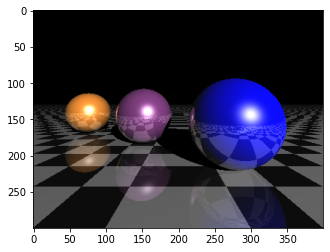

In [49]:
plt.imshow(img)